In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../data/data.csv')
df
'''
Action Items:
    a. Create a model to predict number of free trials generated based on marketing campaign strategy. -
    b. Understand the dataset through EDA -
    c. Explain correlation, patterns, anomalies through visualizations -
    d. Choose an appropriate model -
'''

,REPORT_DATE,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE TRIALS
0,6/9/2023,DR - Direct Response,Title,paid social,7784.31,86401.15
1,8/29/2023,DR - Direct Response,Title,app,2474.31,2956.74
2,7/23/2023,ATL - Above The Line,Title,paid social,10222.82,12513.08
3,12/23/2023,DR - Direct Response,Title,app,49631.87,17207.04
4,8/31/2022,ATL - Above The Line,Title,paid social,2081.06,21758.33
...,...,...,...,...,...,...
14103,2/23/2024,ATL - Above The Line,Brand,bvod,1478.78,16941.67
14104,4/21/2024,ATL - Above The Line,Title,ooh,839.25,5727.03
14105,12/13/2023,ATL - Above The Line,Title,bvod,193796.71,34824.51
14106,2/4/2023,ATL - Above The Line,Brand,paid social,84690.65,25140.77


In [ ]:
'''
1. Data Types Breakdown:
    a. REPORT_DATE: Numerical | (Discrete -> Interval -> DateTime object)
    b. ATL_OR_DR: Categorical | (Nominal  -> String)
    c. CAMPAIGN_TYPE: Categorical | (Nominal -> String)
    d. CHANNEL: Categorical | (Nominal -> String)
    e. COST: Quantitative | (Continuous -> Ratio -> Float)
    f. FREE TRAILS: Quantitative | ( Continuous -> Ratio -> Float)

2. Data Questions/Concerns:
    a. Is 'FREE TRAILS' a generated impression count from another model? How does a a free trial
    lead to continous values instead of discrete?

3. Action Items:
    a. Ensure proper data types across dataframe - DONE
    b. Identify missing data gaps - DONE
    c. Apply encoding on categorical data
'''
colNames = df.columns
categorical = colNames[1:4].values
quantitative = colNames[4::].values
print(f'Categorical: {categorical}\nQuantitative: {quantitative} \n')
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
print(f'Table Dimension: {df.shape} \n')
df.info()

Categorical: ['ATL_OR_DR' 'CAMPAIGN_TYPE ' 'CHANNEL']
Quantitative: ['COST' 'FREE TRIALS'] 

Table Dimension: (14108, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108 entries, 0 to 14107
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   REPORT_DATE     14108 non-null  datetime64[ns]
 1   ATL_OR_DR       14108 non-null  object        
 2   CAMPAIGN_TYPE   14108 non-null  object        
 3   CHANNEL         14108 non-null  object        
 4   COST            14108 non-null  float64       
 5   FREE TRIALS     14108 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 661.4+ KB


### Univariate Analysis

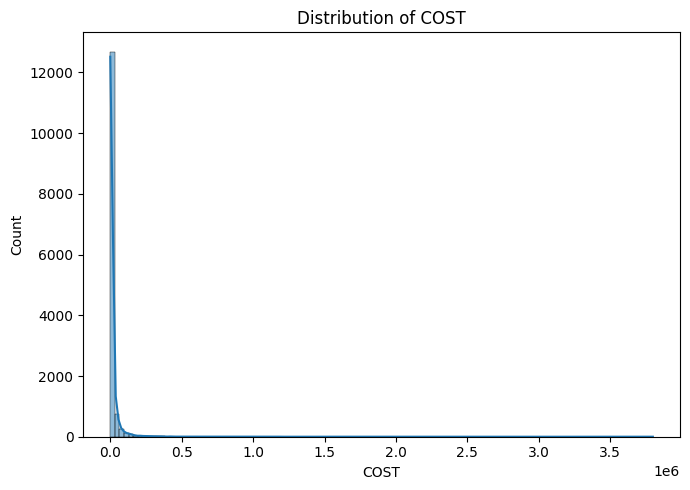

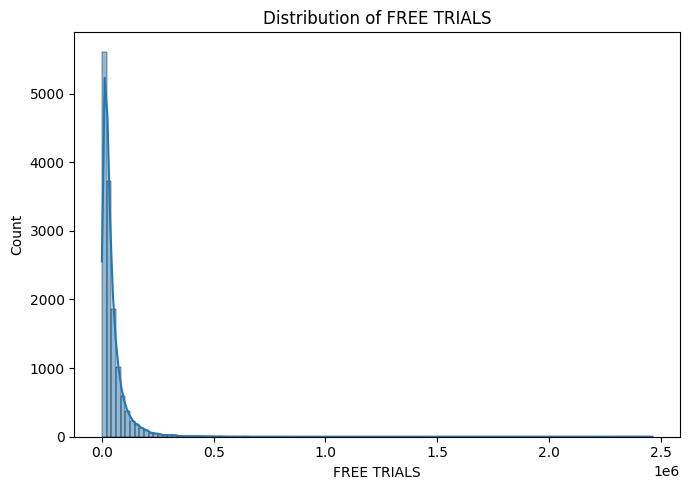

In [4]:
'''
Single Variation Continuous Analysis using Histogram with 118 bins | bin size ~= SqRoot(n):

1. 'COST' Observations/Thoughts/Tasks:
    a. The 1st visual shows a right skewed distribution with outliers on the right side. So, the mean will be greater
    than the median.
    b. The visual shows a wide spread of data where most of the cost to run a campaign is under $250,000. However,
    you have a few campaignsthat cost up to $1M with the highest being 3.75M. Something to explore is finding the
    lag/lead dates of campaigns with high costs and see if there were any significant events/holidays that
    contributed to the spike in cost.
    c. Most of the cluster of cost is to run a campaign is at 0 which is surprising because I wouldn't have guessed
    the majority of campaigns to incur 0 expense. This shows why we need to perform feature engineering and apply
    log transformation on it to better understand the distribution for normalization.
    d. Need to better understand the variance of the data via boxplots for further inspections as well as diving deeper
    into the outliers via IQR's.
    e. Recap: This dimension violates Linear Regression's assumption of normality. Need to log transform this feature
    to normalize the data.

2. 'FREE TRIALS' Observations/Thoughts/Tasks:
    a. The 2nd visual shows a right skewed distribution with outliers on the right side. So, the mean will be greater
    than the median.
    b. The visual shows a wide spread of data where most of the campaigns generate 0 free trials and the rest under
    250,000. However, you have campaignswere very succesful generating over 1M 'FREE TRIALS'. Around 2.5M 'FREE TRIALS'
    was the max.
    c. Need to look into if there is a linear/non-linear relationship bewteen 'COST' and 'FREE TRIALS' to see if there
    is a correlation between the two.My hypothesis being the more you spend on a campaign, the more free trials you
    generate. Will this help answer why there is such a huge variance in'FREE TRIALS'?
    d. Need to better understand the variance of the data via boxplots for further inspections as well as diving deeper
    into the outliers via IQR's.
    e. Recap: This dimension violates Linear Regression's assumption of normality. Need to log transform this feature to
    normalize the data.

3. Action Items:
    a. Log Transformation on 'COST' and 'FREE TRIALS'. - DONE
    b. Single Variation Continuous Analysis using boxplots - DONE
    c. Covaritation Continuous Analysis between 'COST' and 'FREE TRIALS' using a scatterplot. - DONE
'''
for quant_col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.histplot(df[quant_col], kde=True, bins=118)
    plt.title(f'Distribution of {quant_col}')
    plt.tight_layout()
    plt.show()

In [5]:
'''
Descriptive Analysis:
1. 'COST' Observations/Thoughts/Tasks:
    a. Such a high standard deviation, which accounts for units unlike variance, validates the spread from the visuals.
    Understanding what causes this huge varaince will something to keep in mind.
    b. 0-25% of the cost ranged from $0-$945.
    c. 25-50% of the cost ranged from $945-$3,164.
    d. 50-75% of the cost ranged from $3,164-$10,641.
    e. 75-100% of the cost ranged from $10,641-$3.7M.
    f.


2. 'FREE TRIALS' Observations/Thoughts/Tasks:
    a. Such a high standard deviation, which accounts for units unlike variance, validates the spread from the visuals.
    The fact that this is high varaince is a good sign that this is a feature is a good target variable.
    b. The lowest free trial was at 576. So, you can have a campaign that has no expenses and still generate free trials.
    c. 0-25% of the free trials ranged from 576-1,393.
    d. 25-50% of the free trials ranged from 1,393-27,776.
    d. 50-75% of the free trials ranged from 27,776-54,678.
    e. 75-100% of the free trials ranged from 54,678-2.4M.


3. Action Items:
    a. Feature Engineer a KPI metric: 'COST'/'FREE TRAILS' and perform visualizations
    b. Create Boxplot for 'COST' and 'FREE TRAILS' to better understand the variance of the data. - DONE
'''
df[quantitative].describe()

,COST,FREE TRIALS
count,1.410800e+04,1.410800e+04
mean,1.655741e+04,4.545834e+04
std,7.359892e+04,6.040529e+04
min,0.000000e+00,5.762400e+02
25%,9.457675e+02,1.393528e+04
50%,3.164070e+03,2.777694e+04
75%,1.064149e+04,5.467904e+04
max,3.798940e+06,2.463082e+06


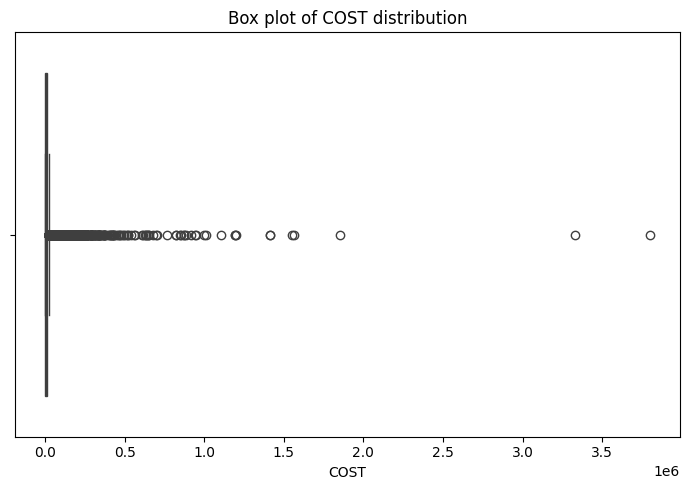

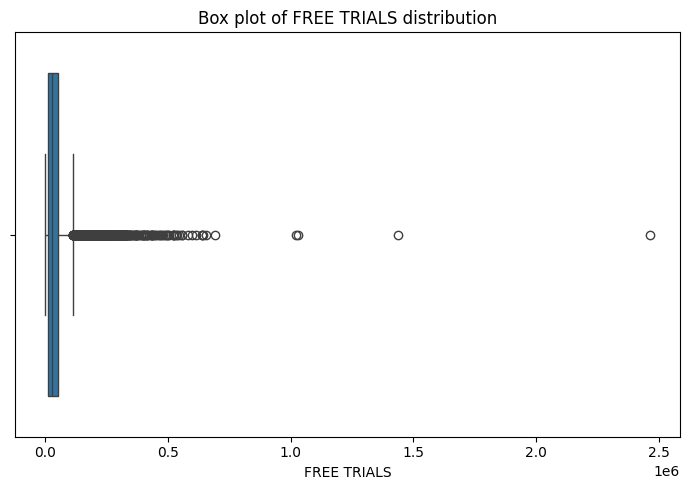

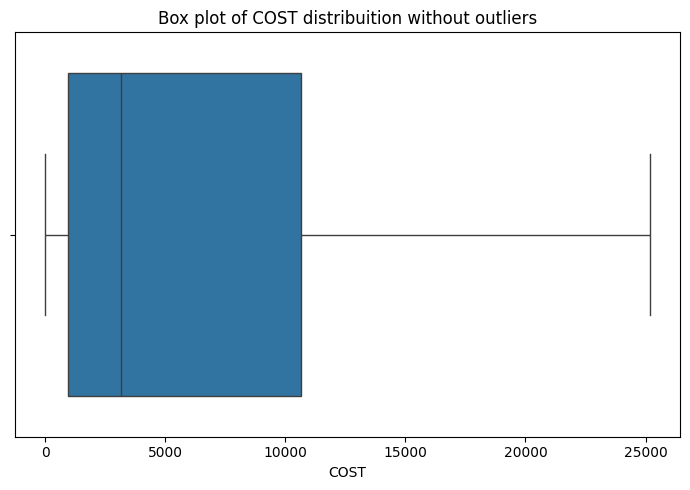

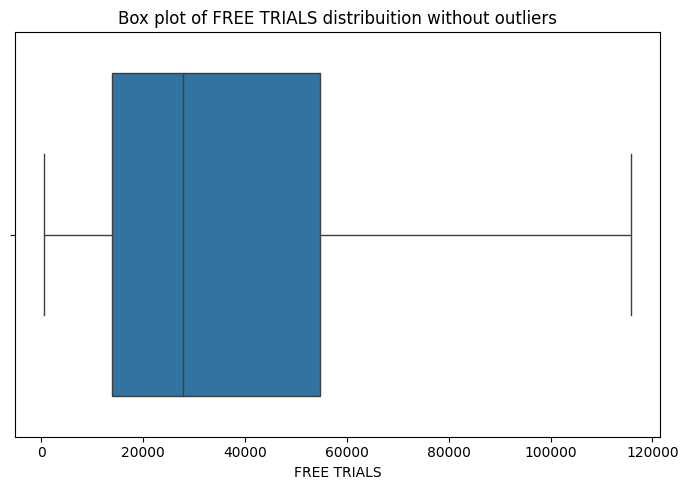

In [6]:
'''
Single Variation Continuous Analysis using BoxPlots:

1. 'COST' + 'FREE TRIALS'  Observations/Thoughts/Tasks:
    a. Very low variance in the data custered the 0-50% range. Whereas once your data increases pass the 50% percentile,
    we notice a wider spread in the data.
    b. We see large clusters of "outlier" data passed the upper whisker - the high frequency of these data points
    leads me to think these aren't outliers to begin with and needs to be transformed which validates our observations
    so far.
    c. We do have extreme outliers in the millions. These can used for further analysis using other metadatalike datetime
    fields.


2. Action Items:
    a. Look into other metadata to see are there any relationships between the 0-25% range of 'COST' and 'FREE TRIALS'
    type campaigns.
'''
for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=col, data=df)
    plt.title(f'Box plot of {col} distribution')
    plt.tight_layout()
    plt.show()

for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=col, data=df, showfliers=False)
    plt.title(f'Box plot of {col} distribuition without outliers')
    plt.tight_layout()
    plt.show()

In [7]:
df[df['FREE TRIALS'] <= df['FREE TRIALS'].quantile(0.50)].sort_values('FREE TRIALS', ascending=False) #14,108

,REPORT_DATE,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE TRIALS
9930,2023-06-01,ATL - Above The Line,Title,bvod,888.71,27775.90
6116,2022-09-11,ATL - Above The Line,Title,cinema,14011.68,27775.16
8692,2022-08-21,ATL - Above The Line,Brand,youtube,8271.85,27775.01
11692,2024-03-23,ATL - Above The Line,Title,tv,46246.47,27769.03
2240,2023-09-19,ATL - Above The Line,Title,youtube,3844.61,27767.25
...,...,...,...,...,...,...
4106,2023-06-12,ATL - Above The Line,Title,bvod,1867.15,971.22
10503,2023-08-24,ATL - Above The Line,Title,cinema,3634.02,827.94
1054,2022-09-16,ATL - Above The Line,Title,cinema,1176.11,719.36
8386,2023-11-13,ATL - Above The Line,Title,youtube,60216.79,705.15


In [8]:
np.exp(10.90)-1

54175.36379669875

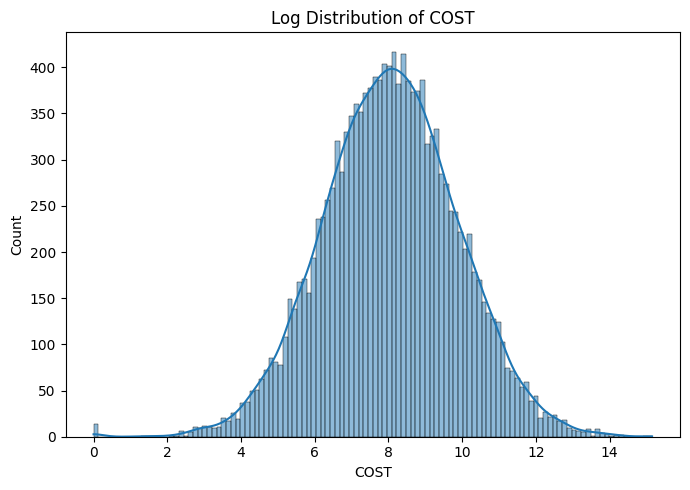

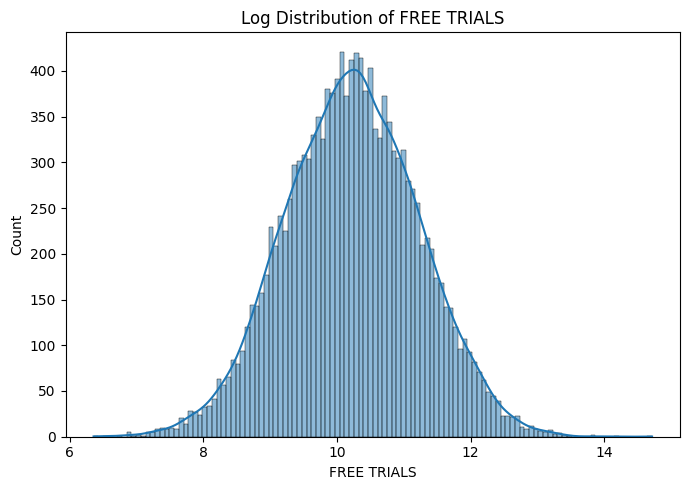

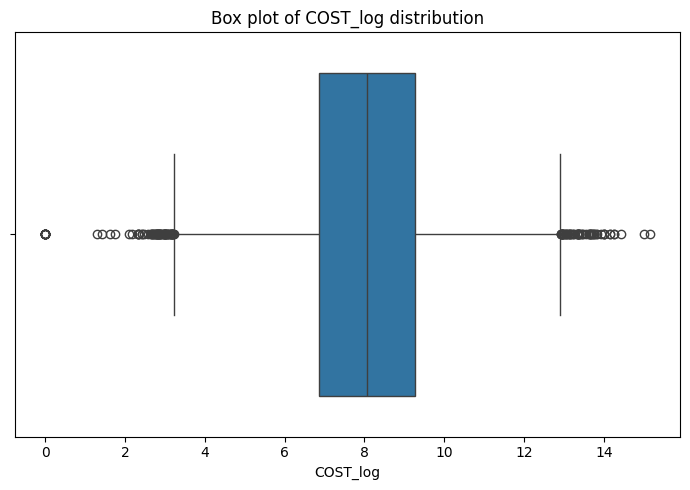

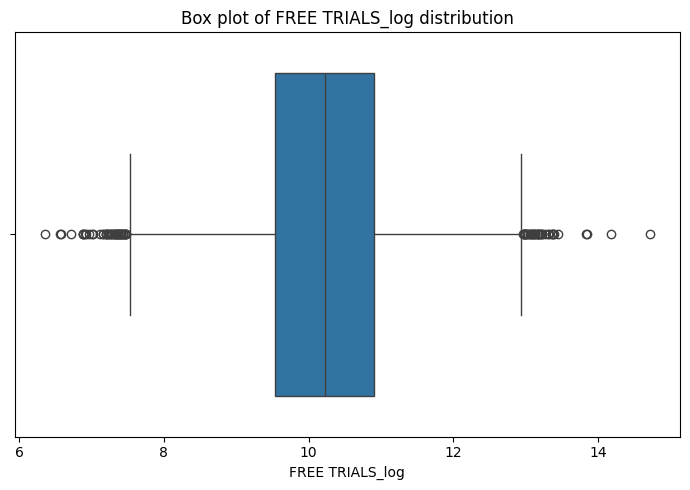

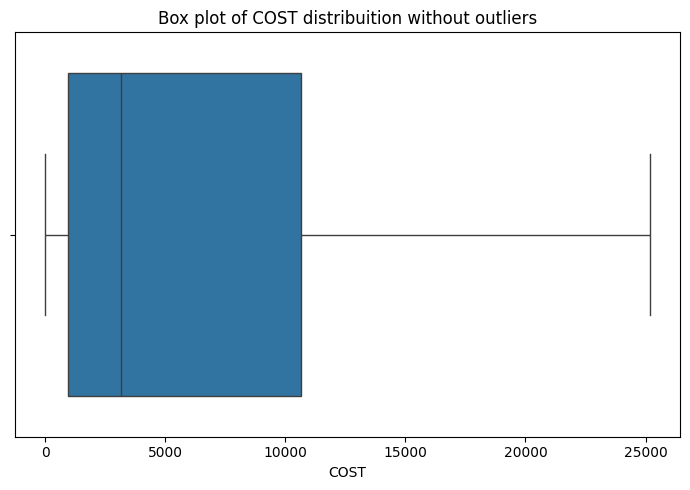

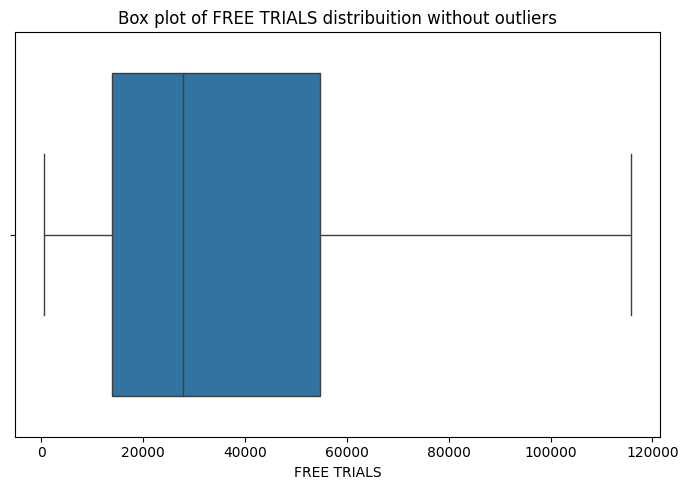

,COST_log,FREE TRIALS_log
count,14108.000000,14108.000000
mean,8.057799,10.228010
std,1.822654,0.998582
min,0.000000,6.358258
25%,6.853054,9.542251
50%,8.059930,10.231998
75%,9.272610,10.909254
max,15.150233,14.716925


In [9]:
'''
Single Variation Log Analysis using Histogram/BoxPlots:

1. 'LOG_COST' Observations/Thoughts/Tasks:
    a. Log transformation is a suitible technique to ensure our data is normally distributed, which longer violates
    linear regression assumptions.
    b. 'COST' median/mean: $3,000 -> normally distribution | 25%: $950 | 75%: $10,600
    c. We have extreme outliers happening at both tails of the data and with large densities. While the left tail
    that might be fine because cost is minimal, the right tail might provide opportunities to reduce expenses or
    determine a more efficient campaign strategy
    d. Variance is smaller from 0-25% range; but drastically increases with higher costs.

2.  'LOG_FREE TRIALS' Observations/Thoughts/Tasks:
    a. Log transformation is a suitible technique to ensure our data is normally distributed, which longer violates
    linear regression assumptions.
    b. 'FREE TRIALS' median/mean: 22,000 -> normally distribution | 25%: 13,903 | 75%: 54,000
    c. We have extreme outliers happening at both tails of the data and with large densities. Both tails would be
    worth looking into. For the right tail, you can see how many of the free trials became new customers to quantify
    the success of running the free trial campaign. Also, we could explore why we have such low generations of free
    trials.
    d. Variance is smaller from 0-25% range; but drastically increases more free trials.

3. Action Items:
    a. Using the log percentiles to segment the data for further analysis.
    B. Create Covariation Analysis with 'LOG_COST' and 'LOG_FREE TRIALS' using a scatterplot. - DONE
'''
for quant_col in quantitative:
    plt.figure(figsize=(7, 5))
    log_transformed = np.log1p(df[quant_col])
    df[f'{quant_col}_log'] = log_transformed
    sns.histplot(log_transformed, kde=True, bins=118)
    plt.title(f'Log Distribution of {quant_col}')
    plt.tight_layout()
    plt.show()

for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=df[f'{col}_log'], data=df)
    plt.title(f'Box plot of {col}_log distribution')
    plt.tight_layout()
    plt.show()

for col in quantitative:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x=col, data=df, showfliers=False)
    plt.title(f'Box plot of {col} distribuition without outliers')
    plt.tight_layout()
    plt.show()

df[['COST_log','FREE TRIALS_log']].describe()

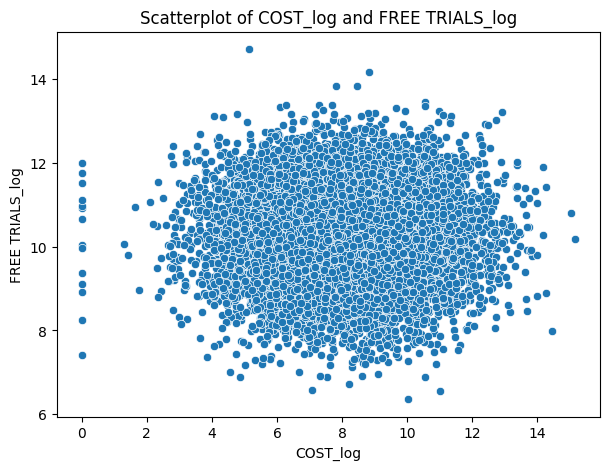

In [10]:
'''
Covariation Analysis using Scatterplot:

1. 'LOG_COST' + 'LOG_FREE TRIALS' Observations/Thoughts/Tasks:
    a. Positive, non-linear relationship. A higher expense in a campaign doesn't necessarily mean more free trials.
    This makes me reject my earlier assumption.
    b. We see a strong cluster of data around 6-10 in log cost and 8-12 in log free trials. This also gives us
    opporuntiies to understand why certain campaigns that cost bewteen 6-10 generate such wide ranges of free tials.
    What makes certain campaigns more successful over others since cost doesn't seem to be a strong indicator.
    c. Outliers with low cost and above free trails generated near the average range of data. High cost with low free
    trials. And high free trail with low cost.

2. Action Items:
    a. Add cateogircal data to the scatterplot to see if there are any relationships between the two.
'''
plt.figure(figsize=(7, 5))
sns.scatterplot(x='COST_log', y='FREE TRIALS_log', data=df)
plt.title('Scatterplot of COST_log and FREE TRIALS_log')
plt.show()


In [16]:
import pandas as pd
from scipy.stats import pearsonr

# Assuming your data is in a DataFrame named 'df' with columns 'COST_log' and 'FREE TRIALS_log'

# Calculate the Pearson correlation coefficient
corr_coef, p_value = pearsonr(df['COST'], df['FREE TRIALS_log'])

print(f"Pearson correlation coefficient: {corr_coef}")
print(f"P-value: {p_value}")

# Interpret the results
if abs(corr_coef) > 0.7:
    print("Strong correlation")
elif abs(corr_coef) > 0.3:
    print("Moderate correlation")
else:
    print("Weak correlation")

if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson correlation coefficient: 0.007187326128184592
P-value: 0.3933127175997242
Weak correlation
The correlation is not statistically significant.


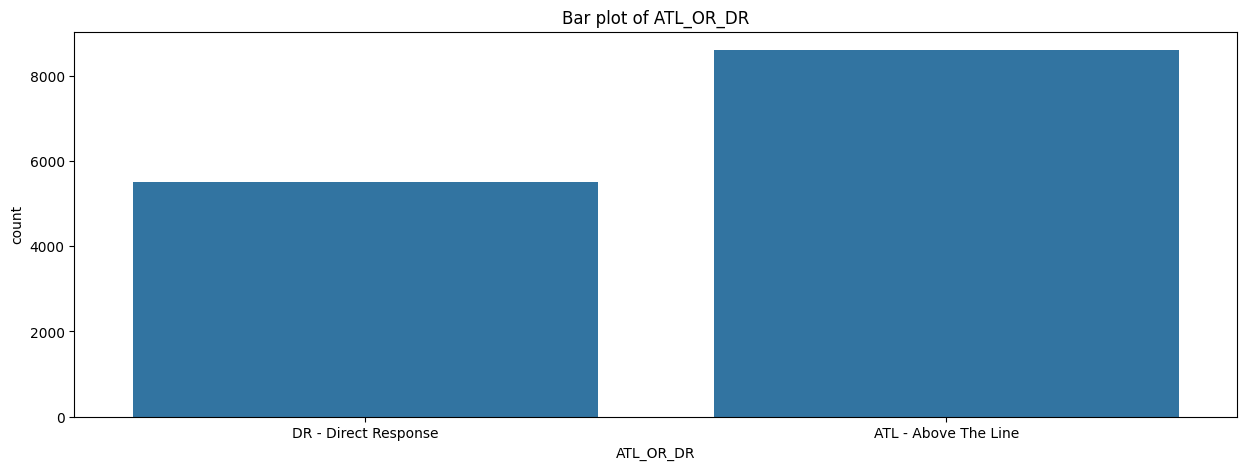

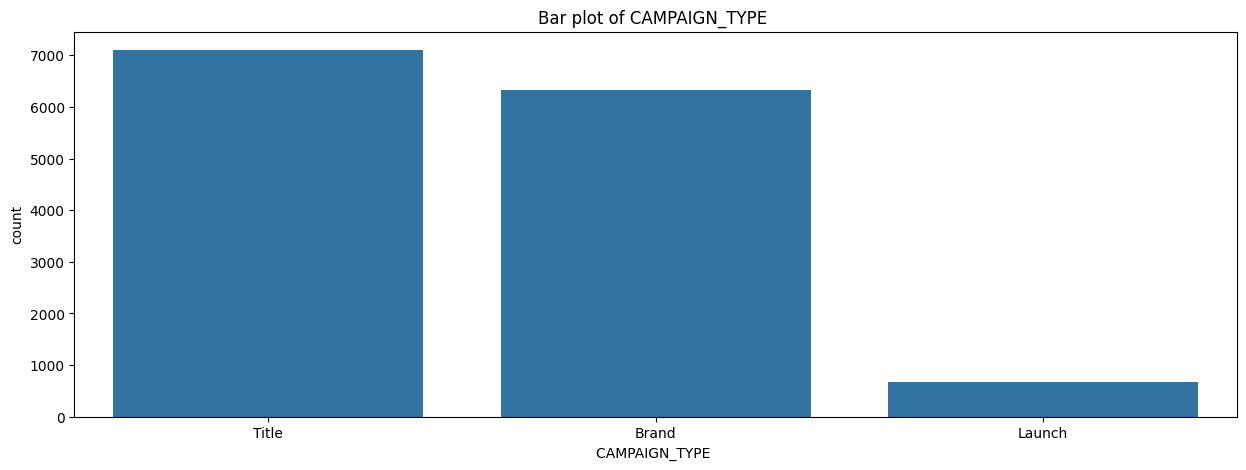

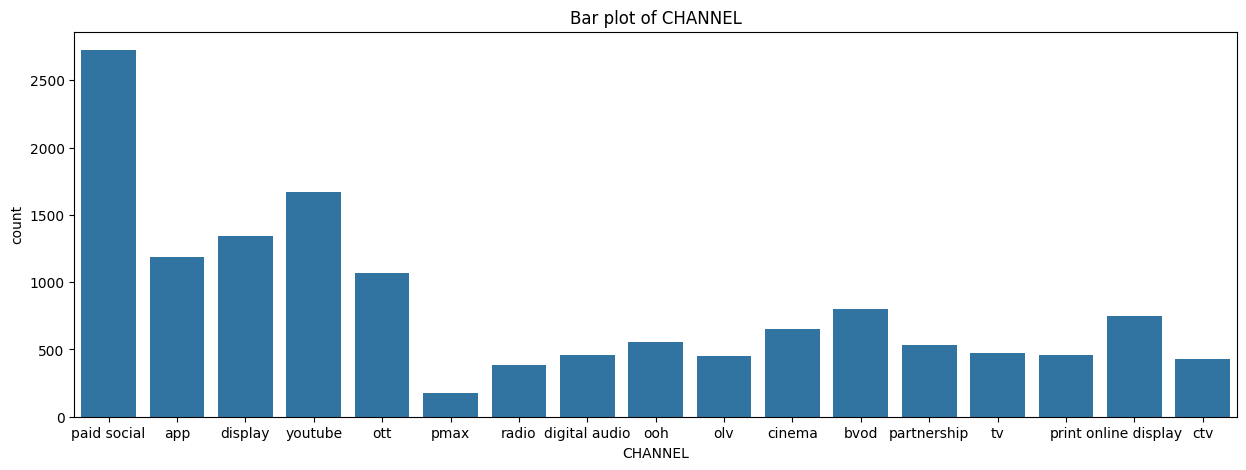

In [129]:
'''
Single Variation Categorical Analysis using Barchart:

1. 'ATL_OR_DR' Observations/Thoughts/Tasks:
    a. Most campaigns are ATL (Above The Line) rather than DR (Direct Response). This aligns with the need for consistent
    brand-building efforts compared to the more sporadic nature of direct response campaigns.
    b. DR campaigns are often tied to specific events, such as new product launches, national holidays, or one-time
    promotions. Their infrequent nature explains the smaller count.

2. 'CAMPAIGN_TYPE' Observations/Thoughts/Tasks:
    a. There are no Promotional Campaigns.
    b.Brand and Title campaigns dominate, while Launch campaigns are infrequent. This aligns with typical product
    lifecycles, where new product launches are less frequent compared to ongoing brand-building efforts.
    c. Brand/Title campaigns may have lower costs due to an already established audience, reducing the need for wide
    coverage across multiple channels.
    d. Cost for these campaigns is likely less variable, while free trials generated may show high variance. Loyal
    customers might quickly adopt new trials, while others may stick to their current product preferences.


3. 'CHANNEL' Observations/Thoughts/Tasks:
    a. Top 2 channels: Social and YouTube. Bottom 3 channels: Pmax and Radio
    b. While Social and YouTube dominate, simply reallocating resources from low-performing channels (e.g., Radio)
    to top channels may not be ideal. Customer segments from different channels could vary significantly.
    c. Costs to run campaigns on different channels should be analyzed to assess the trade-offs of reallocating resources.

4. Action Items:
    a. Covariation Analysis between Categorical & Continuous' using Scatterplot and hue
    b. Covariation Analysis between categorical and continuous using boxplot and barcharts
    c. Validate assumptions through visuals and correlation analysis:
        i. ATL campaigns are costlier but generate broader reach, whereas DR campaigns are more focused and efficient.
        ii. ATL likely shows higher variance in free trials, while DR campaigns generate more focused attention and
        higher free trial counts per campaign
        ii. Launch campaigns require higher costs and incentives to attract new users, driving significantly higher free
        trial counts.
        iii. Top 5 channels (e.g., Social, YouTube) are more cost-efficient for free trial generation, while bottom
        performing channels cater to niche segments.
        iv. Outliers in cost or free trials are tied to DR campaigns, Launch campaigns, or specific niche channels like
        IoT.
        v. outliers are more assoociated with DR and launch and an iOT channel.
'''
for cat in categorical:
    plt.figure(figsize=(15, 5))
    sns.countplot(x=cat, data=df)
    plt.title(f'Bar plot of {cat}')
    plt.show()

In [130]:
 quantitative

array(['COST', 'FREE TRIALS'], dtype=object)

C:\Users\cheng\AppData\Local\Temp\ipykernel_20728\316648356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")


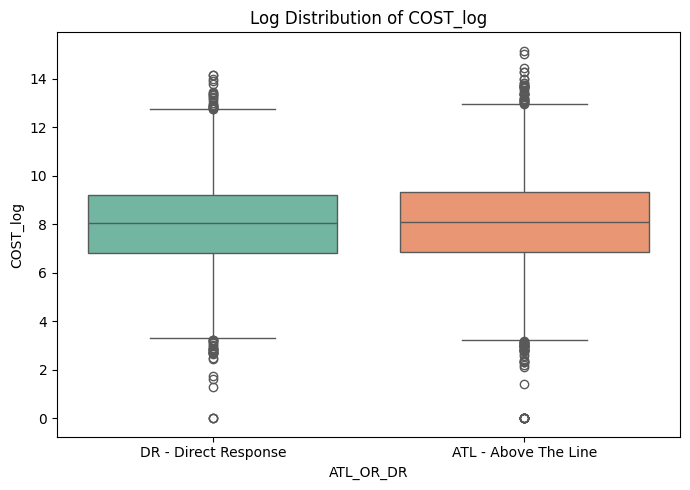

C:\Users\cheng\AppData\Local\Temp\ipykernel_20728\316648356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")


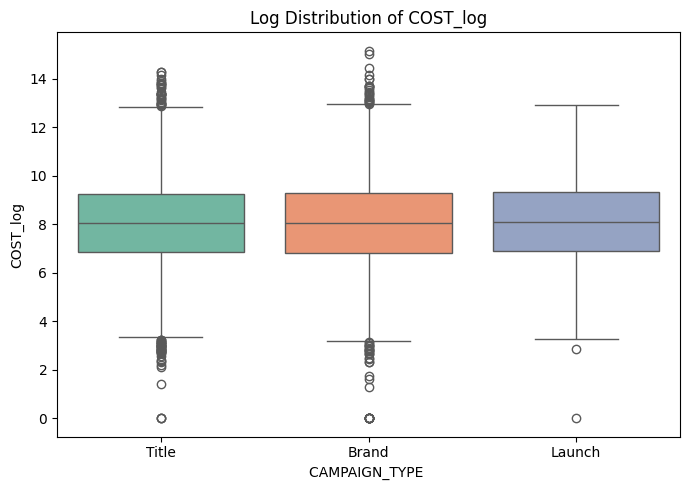

C:\Users\cheng\AppData\Local\Temp\ipykernel_20728\316648356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")


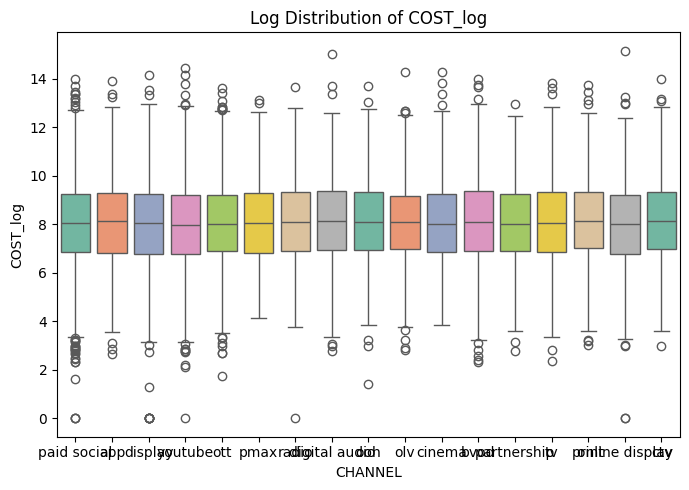

C:\Users\cheng\AppData\Local\Temp\ipykernel_20728\316648356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")


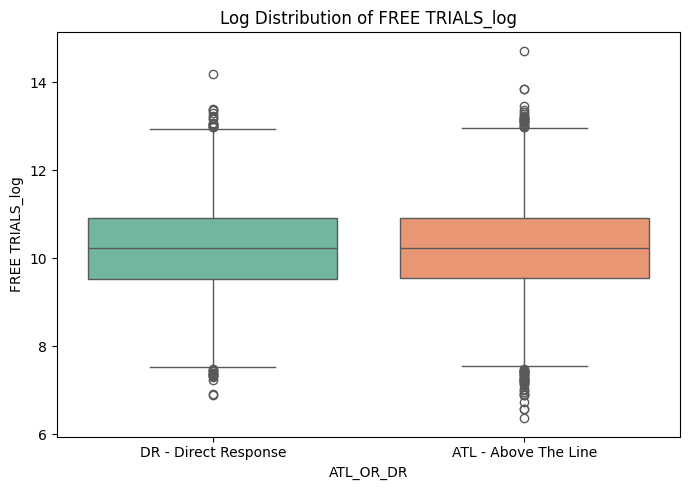

C:\Users\cheng\AppData\Local\Temp\ipykernel_20728\316648356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")


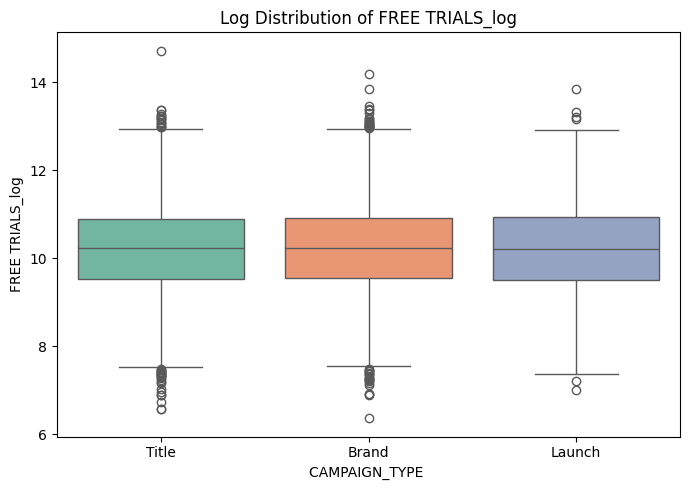

C:\Users\cheng\AppData\Local\Temp\ipykernel_20728\316648356.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")


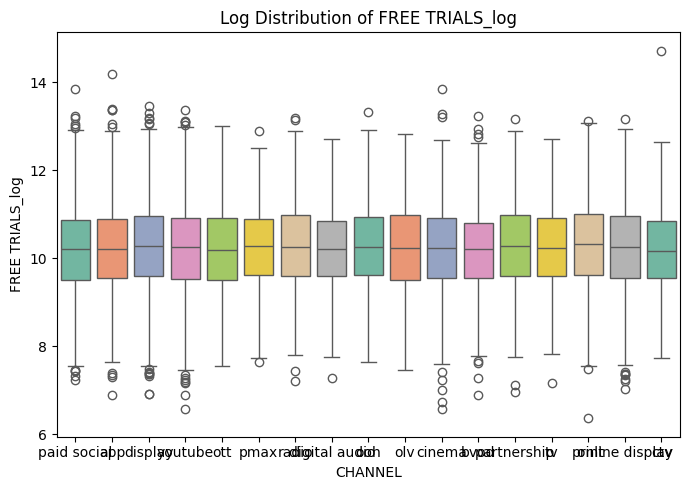

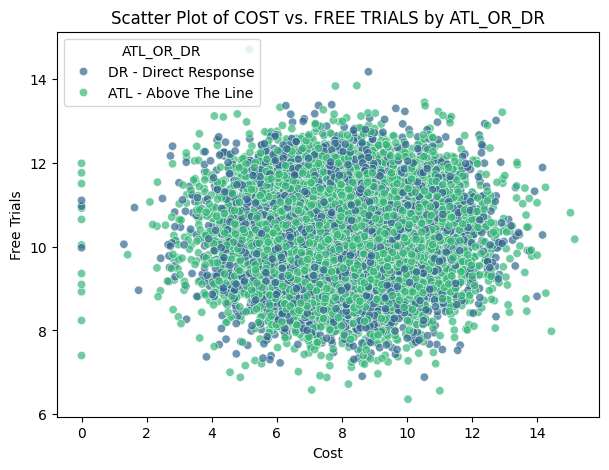

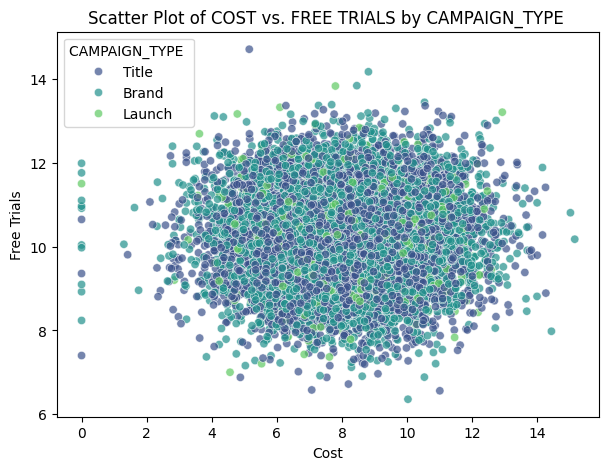

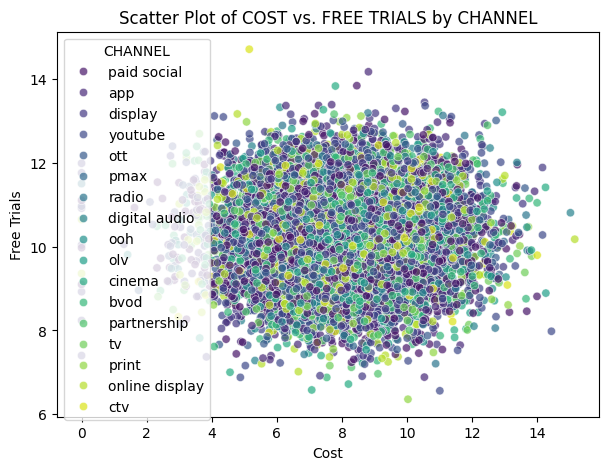

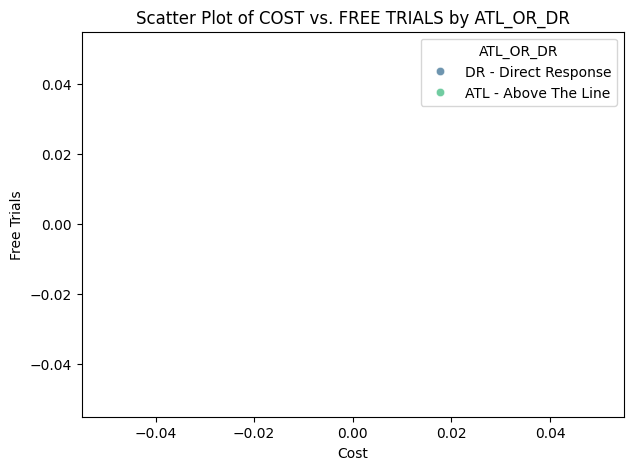

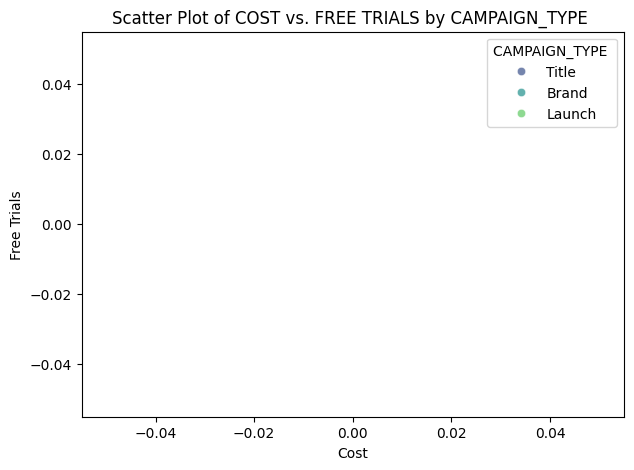

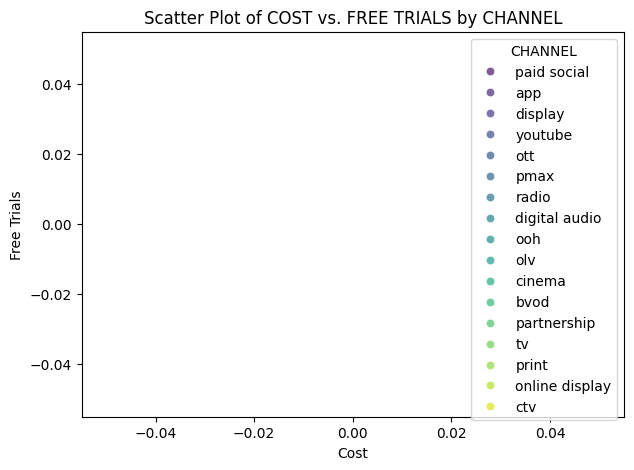

In [131]:
'''
ATL (Above The Line) vs. Cost
Both campaign strategy share similar varaince in their costs distribution.

campaign_type (Brand) vs. Cost
Both Title/Brand share similar cost behaviors. Meanwhile, Launch offers more variance
in their cost distribution. Which makes sense since maintaining a brand is more consistent
than launching a new product.

'''
log_quantitative = [f'{quant}_log' for quant in quantitative]
for quant_col in log_quantitative:
    for cat in categorical:
        plt.figure(figsize=(7, 5))
        sns.boxplot(data=df, x=cat, y=quant_col, palette="Set2")

        #sns.histplot(data=df, x=f'{quant_col}_log', kde=True, hue=cat, bins=118)
        plt.title(f'Log Distribution of {quant_col}')
        plt.tight_layout()
        plt.show()



# # Scatterplot with hue for ATL_OR_DR

for cat in categorical:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x='COST_log', y='FREE TRIALS_log', hue=cat, data=df, alpha=0.7, palette='viridis'
    )
    plt.title(f'Scatter Plot of COST vs. FREE TRIALS by {cat}')
    plt.xlabel('Cost')
    plt.ylabel('Free Trials')
    plt.show()


for cat in categorical:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x='COST_log', hue=cat, data=df, alpha=0.7, palette='viridis'
    )
    plt.title(f'Scatter Plot of COST vs. FREE TRIALS by {cat}')
    plt.xlabel('Cost')
    plt.ylabel('Free Trials')
    plt.show()



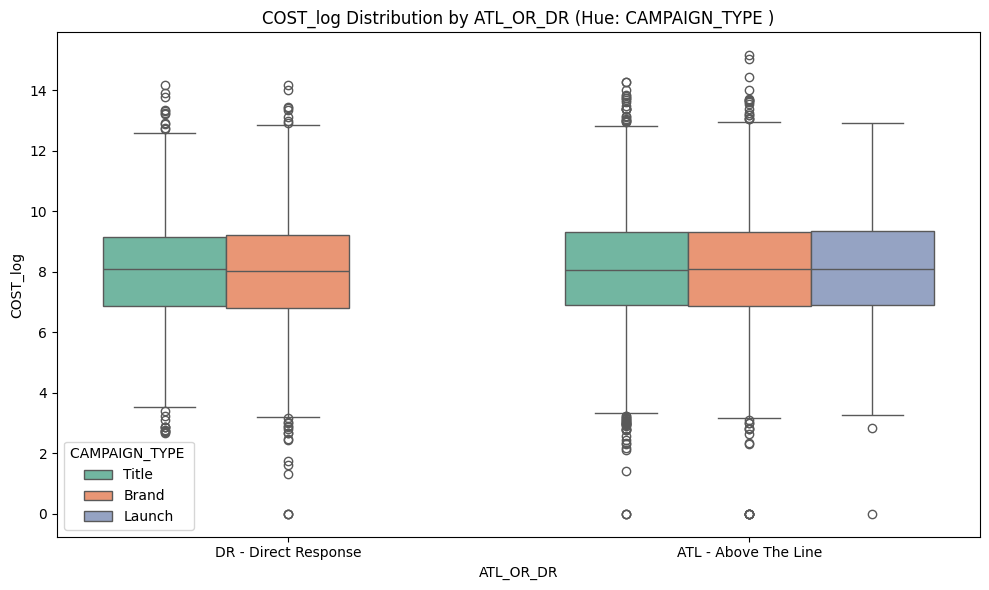

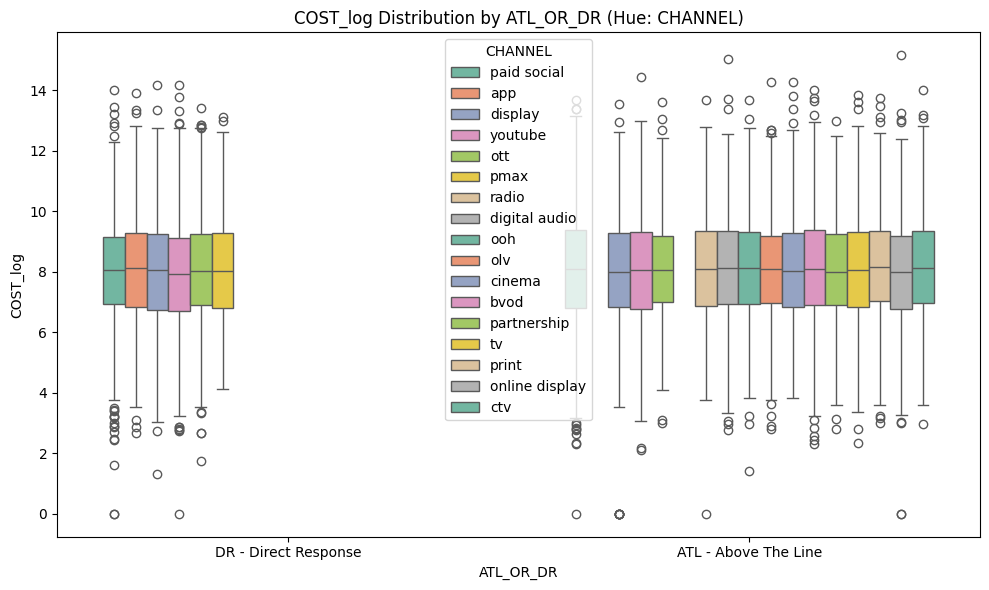

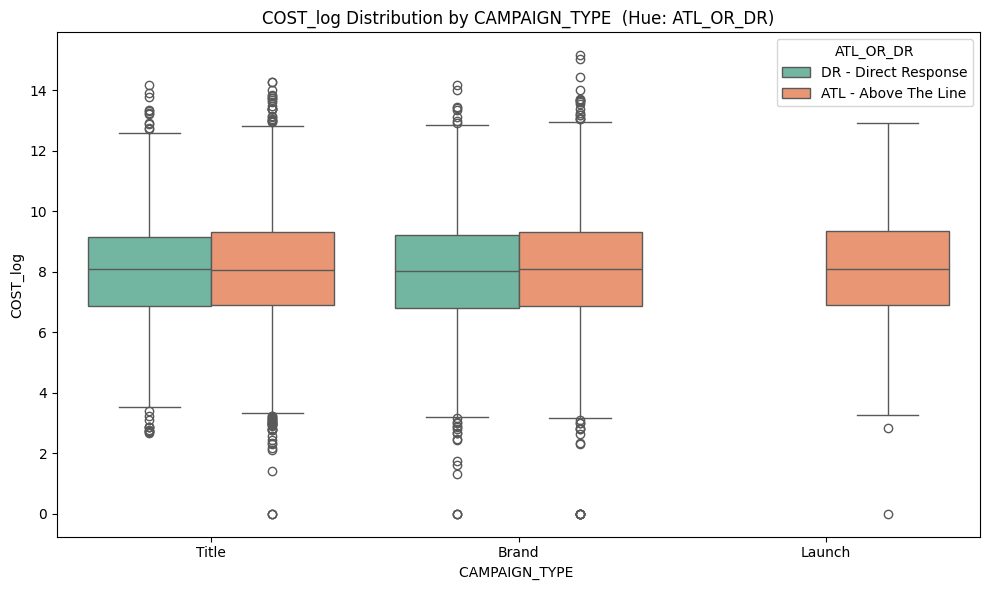

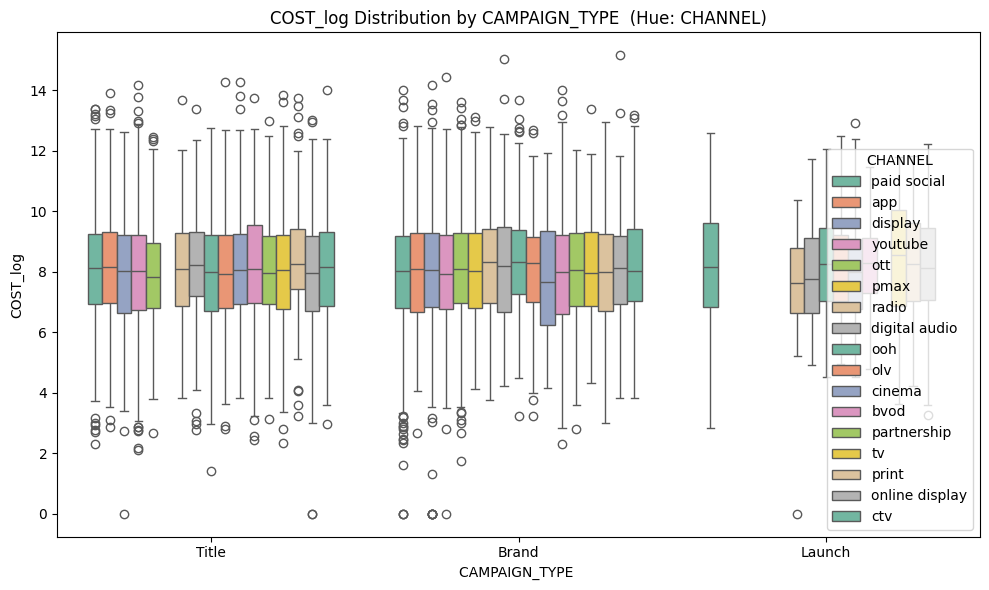

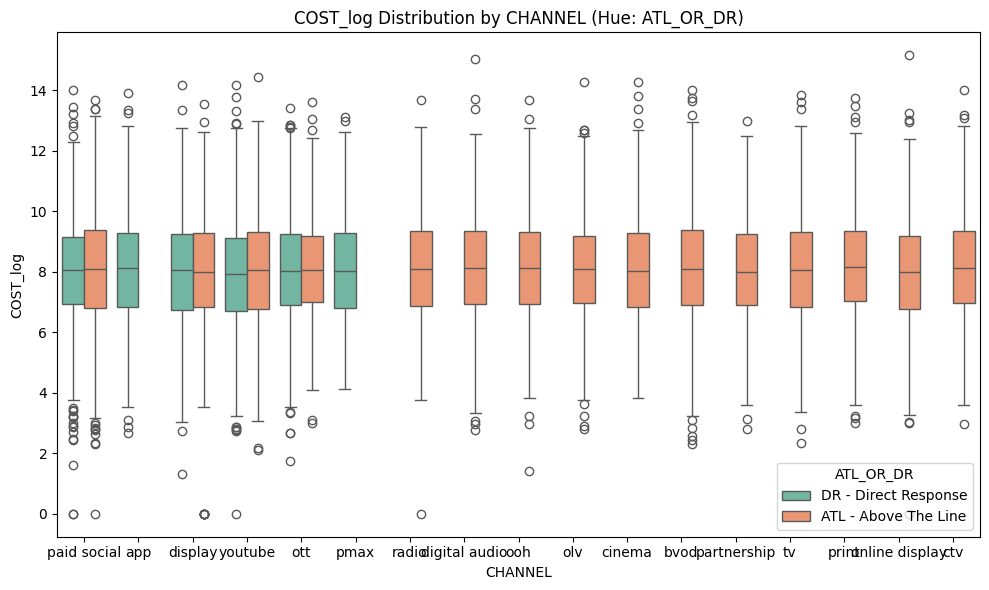

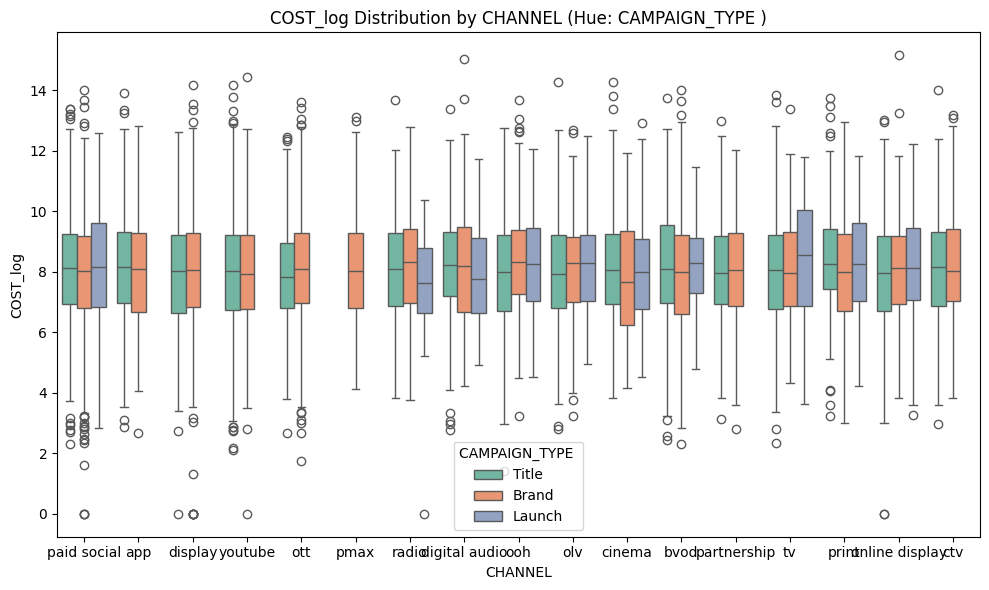

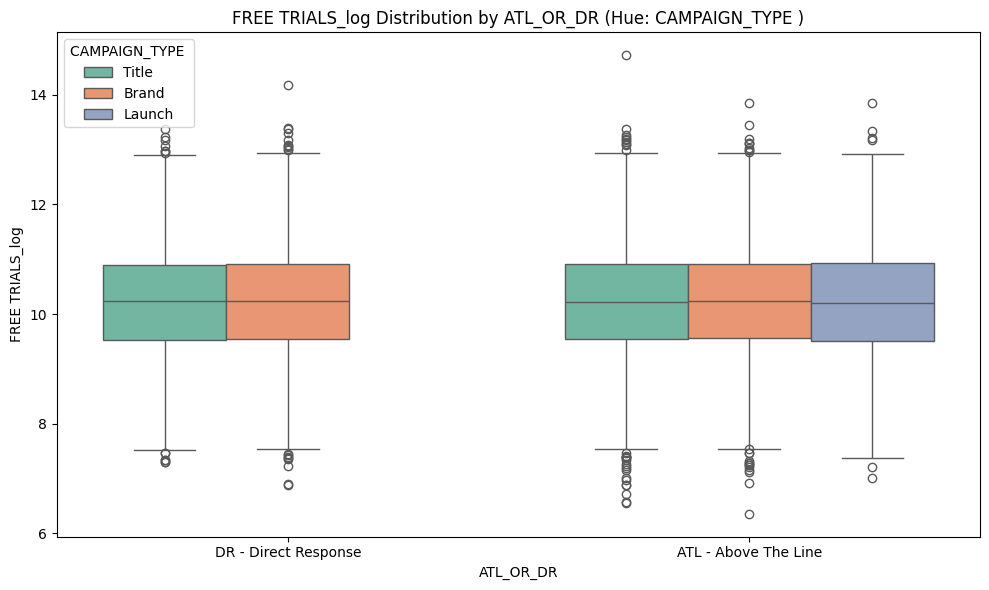

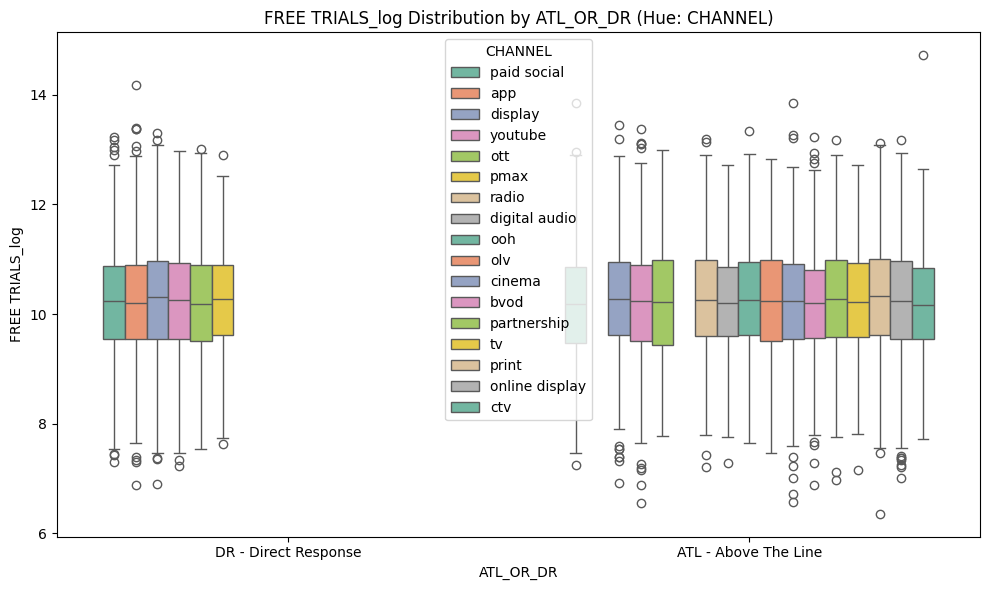

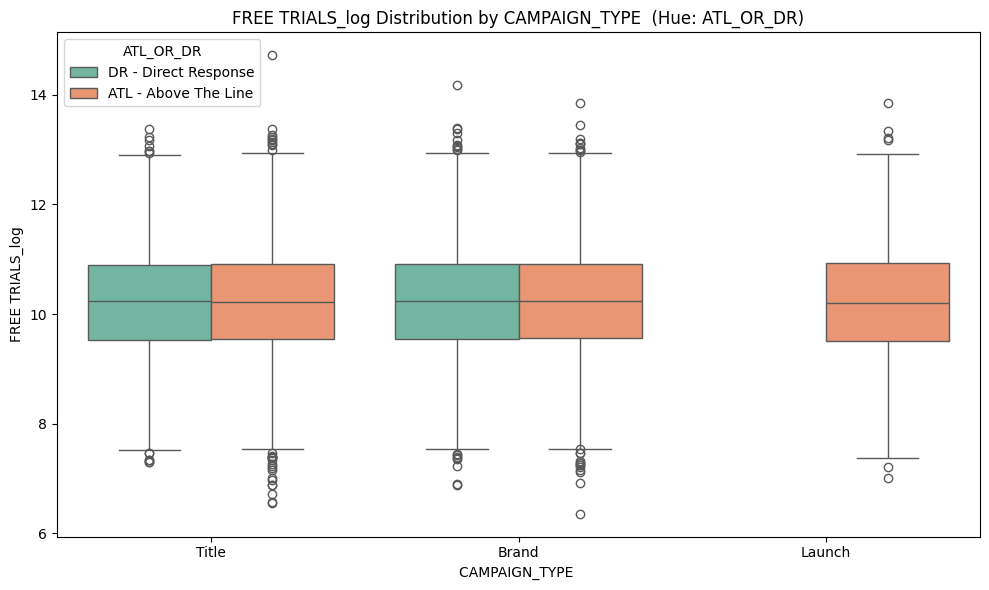

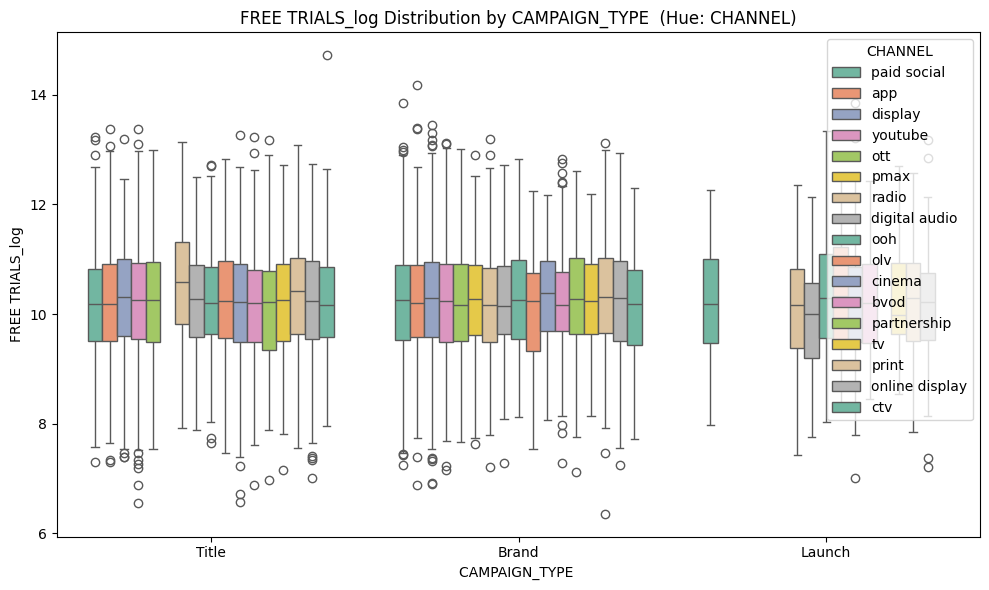

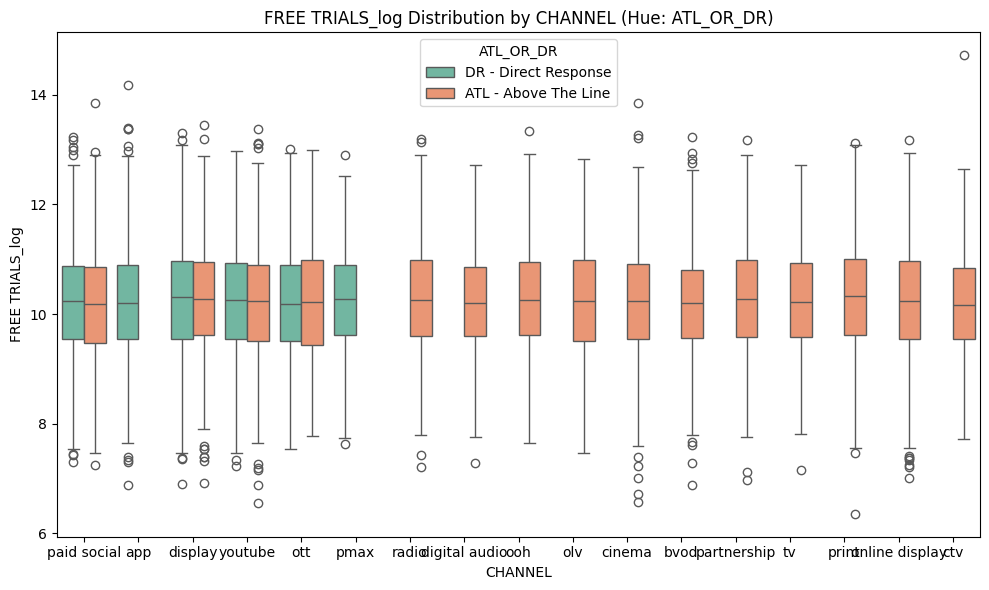

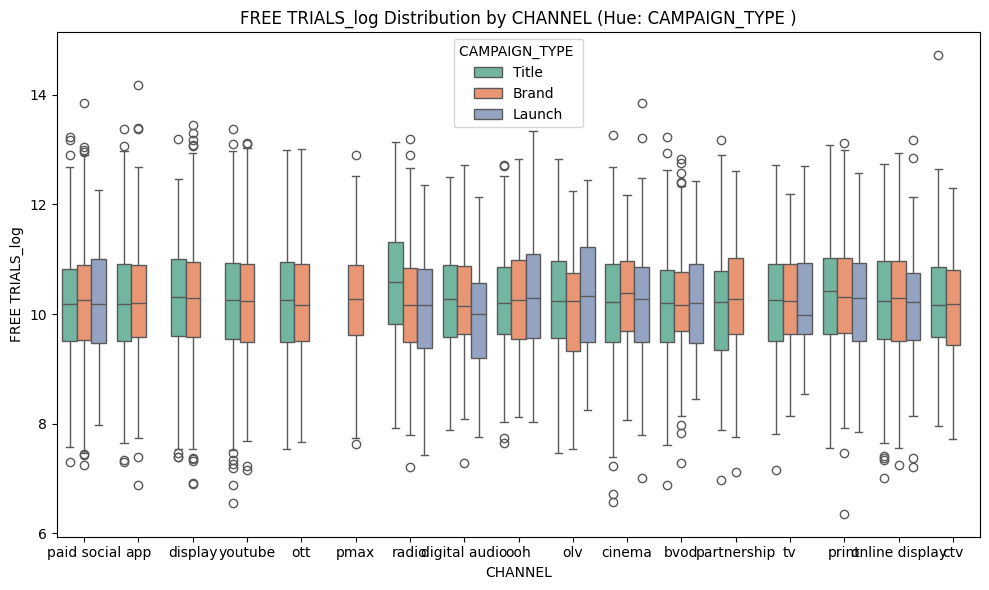

In [132]:
log_quantitative = [f'{quant}_log' for quant in quantitative]
for quant_col in log_quantitative:
    for cat_col in categorical:
        for hue_col in categorical:
            # Skip if hue and x are the same column
            if cat_col == hue_col:
                continue

            plt.figure(figsize=(10, 6))

            # Create a boxplot for the current combination of variables
            sns.boxplot(data=df, x=cat_col, y=quant_col, hue=hue_col, palette="Set2")

            # Add labels and title dynamically
            plt.title(f"{quant_col} Distribution by {cat_col} (Hue: {hue_col})")
            plt.xlabel(cat_col)
            plt.ylabel(quant_col)
            plt.legend(title=hue_col)
            plt.tight_layout()
            plt.show()